In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.naive_bayes import MultinomialNB

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

C:\Users\91889\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## 1.1 Reading Data

In [ ]:
project_data = pd.read_csv('train_data.csv', nrows=100000)
resource_data = pd.read_csv('resources.csv')
project_data = project_data[pd.notnull(project_data['teacher_prefix'])]


In [1]:
project_data.isnull().sum()

NameError: name 'project_data' is not defined

In [ ]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

In [ ]:
y = project_data['project_is_approved'].values
project_data.drop(['project_is_approved'], axis=1, inplace=True)
project_data.head(1)



In [ ]:
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace(' ', '_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace('-', '_')
project_data.head(2)

## 1.3 preprocessing of `project_subject_categories`


In [7]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())

In [8]:
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,clean_categories
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,05-12-2016 13:43,Grades_PreK_2,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,Literacy_Language
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,25-10-2016 09:22,Grades_6_8,"Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,History_Civics Health_Sports


## 1.3 preprocessing of `project_subject_subcategories`

In [9]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

In [10]:
project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,05-12-2016 13:43,Grades_PreK_2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,Literacy_Language,ESL Literacy
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,25-10-2016 09:22,Grades_6_8,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,History_Civics Health_Sports,Civics_Government TeamSports


## 1.4 Merging datasets

In [11]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(5)

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21
2,p000003,298.97,4
3,p000004,1113.69,98
4,p000005,485.99,8


In [12]:
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [13]:
project_data.head(1)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,price,quantity
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,05-12-2016 13:43,Grades_PreK_2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,Literacy_Language,ESL Literacy,154.6,23


## 1.3 Text preprocessing

In [14]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [15]:
# we get the cost of the project using resource.csv file
resource_data.head(5)

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45
3,p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59
4,p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95


In [16]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [17]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [18]:
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|███████████████████████████████████████████████████████████████████████████| 99997/99997 [05:11<00:00, 321.24it/s]


In [19]:
project_data["essay"] = preprocessed_essays

project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,price,quantity,essay
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,05-12-2016 13:43,Grades_PreK_2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,Literacy_Language,ESL Literacy,154.6,23,my students english learners working english s...
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,25-10-2016 09:22,Grades_6_8,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,History_Civics Health_Sports,Civics_Government TeamSports,299.0,1,our students arrive school eager learn they po...


In [20]:
preprocessed_titles = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    title = decontracted(sentance)
    title = title.replace('\\r', ' ')
    title = title.replace('\\"', ' ')
    title = title.replace('\\n', ' ')
    title = re.sub('[^A-Za-z0-9]+', ' ', title)
    # https://gist.github.com/sebleier/554280
    title = ' '.join(e for e in title.split() if e not in stopwords)
    preprocessed_titles.append(title.lower().strip())

100%|██████████████████████████████████████████████████████████████████████████| 99997/99997 [00:11<00:00, 8503.13it/s]


In [21]:
project_data["project_title"] = preprocessed_titles

project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,price,quantity,essay
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,05-12-2016 13:43,Grades_PreK_2,educational support english learners home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,Literacy_Language,ESL Literacy,154.6,23,my students english learners working english s...
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,25-10-2016 09:22,Grades_6_8,wanted projector hungry learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,History_Civics Health_Sports,Civics_Government TeamSports,299.0,1,our students arrive school eager learn they po...


## 1.5 Sorting according to date

In [22]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(project_data.columns)]


#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])
project_data.drop('project_submitted_datetime', axis=1, inplace=True)
project_data.sort_values(by=['Date'], inplace=True)


# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]


project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,price,quantity,essay
70254,98044,p001225,9568c8968f974c1fc34def91394cb005,Ms.,CA,2016-01-05 01:05:00,Grades_PreK_2,animal adaptation study ant farm,"The ants go marching two, by two through our a...",Our school is situated in a small neighborhood...,My students will use ant farm kits and books a...,And farms and materials to support our learnin...,"My students need an ant farm kit, models of th...",15,Math_Science Literacy_Language,Health_LifeScience Literacy,172.04,18,the ants go marching two two adaptation lesson...
31475,47750,p185738,3afe10b996b7646d8641985a4b4b570d,Mrs.,UT,2016-01-05 01:05:00,Grades_PreK_2,math fun,"\""The only way to learn mathematics is to do m...",My students love coming to school and working ...,My students will be using these math manipulat...,Learning about money is important so the stude...,"My students need base ten blocks, realistic pl...",0,Math_Science,Mathematics,218.17,12,the way learn mathematics mathematics paul hal...


In [23]:
X=project_data

## 1.6 Splitting data

In [24]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)
  

In [25]:
print(X.shape)
print(X_train.shape)
print(X_cv.shape)
print(X_test.shape)
print(y.shape)
print(y_train.shape)
print(y_cv.shape)
print(y_test.shape)


(99997, 19)
(44887, 19)
(22110, 19)
(33000, 19)
(99997,)
(44887,)
(22110,)
(33000,)


we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data (optinal)
       
       - quantity : numerical (optinal)
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

In [26]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

# Assignment 4: Naive Bayes 

<h2>2.1 Make Data Model Ready: encoding numerical, categorical features</h2>

In [27]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
categories_ohe_train = vectorizer.fit_transform(X_train['clean_categories'].values)
categories_ohe_cv = vectorizer.transform(X_cv['clean_categories'].values)
categories_ohe_test = vectorizer.transform(X_test['clean_categories'].values)

print("After vectorizations")
print(categories_ohe_train.shape, y_train.shape)
print(categories_ohe_cv.shape, y_cv.shape)
print(categories_ohe_test.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(44887, 9) (44887,)
(22110, 9) (22110,)
(33000, 9) (33000,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


In [28]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
subcategories_ohe_train = vectorizer.fit_transform(X_train['clean_subcategories'].values)
subcategories_ohe_cv = vectorizer.transform(X_cv['clean_subcategories'].values)
subcategories_ohe_test = vectorizer.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(subcategories_ohe_train.shape, y_train.shape)
print(subcategories_ohe_cv.shape, y_cv.shape)
print(subcategories_ohe_test.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(44887, 30) (44887,)
(22110, 30) (22110,)
(33000, 30) (33000,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


In [29]:
#vectorizer = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values)
X_train_state_ohe = vectorizer.fit_transform(X_train['school_state'].values)
X_cv_state_ohe = vectorizer.transform(X_cv['school_state'].values)
X_test_state_ohe = vectorizer.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_cv_state_ohe.shape, y_cv.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(44887, 51) (44887,)
(22110, 51) (22110,)
(33000, 51) (33000,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


In [30]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer.fit_transform(X_train['teacher_prefix'].values)
X_cv_teacher_ohe = vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_cv_teacher_ohe.shape, y_cv.shape)
print(X_test_teacher_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(44887, 5) (44887,)
(22110, 5) (22110,)
(33000, 5) (33000,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


In [31]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer.fit_transform(X_train['project_grade_category'].values)
X_cv_grade_ohe = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)
print(X_cv_grade_ohe.shape, y_cv.shape)
print(X_test_grade_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(44887, 4) (44887,)
(22110, 4) (22110,)
(33000, 4) (33000,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


<h2>2.2 Make Data Model Ready: encoding eassay, and project_title</h2>

In [32]:
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=50000)
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer.fit_transform(X_train['essay'].values)
X_cv_essay_bow = vectorizer.transform(X_cv['essay'].values)
X_test_essay_bow = vectorizer.transform(X_test['essay'].values)

                                        
print("After BOW vectorizations")
print(X_train_essay_bow.shape, y_train.shape)
print(X_cv_essay_bow.shape, y_cv.shape)
print(X_test_essay_bow.shape, y_test.shape)
print("="*100)


(44887, 19) (44887,)
(22110, 19) (22110,)
(33000, 19) (33000,)
After BOW vectorizations
(44887, 50000) (44887,)
(22110, 50000) (22110,)
(33000, 50000) (33000,)


In [33]:
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=50000)
vectorizer.fit(X_train['project_title'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_title_bow = vectorizer.fit_transform(X_train['project_title'].values)
X_cv_title_bow = vectorizer.transform(X_cv['project_title'].values)
X_test_title_bow = vectorizer.transform(X_test['project_title'].values)

                                        
print("After vectorizations")
print(X_train_title_bow.shape, y_train.shape)
print(X_cv_title_bow.shape, y_cv.shape)
print(X_test_title_bow.shape, y_test.shape)
print("="*100)


(44887, 19) (44887,)
(22110, 19) (22110,)
(33000, 19) (33000,)
After vectorizations
(44887, 3789) (44887,)
(22110, 3789) (22110,)
(33000, 3789) (33000,)


In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=50000)
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data

X_train_essay_tfidf = vectorizer.fit_transform(X_train['essay'].values)
X_cv_essay_tfidf = vectorizer.transform(X_cv['essay'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['essay'].values)

print("After TFIDF vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_cv_essay_tfidf.shape, y_cv.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
print("="*100)


After TFIDF vectorizations
(44887, 50000) (44887,)
(22110, 50000) (22110,)
(33000, 50000) (33000,)


In [35]:
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1,4), max_features=50000)
vectorizer.fit(X_train['project_title'].values) # fit has to happen only on train data

X_train_title_tfidf = vectorizer.fit_transform(X_train['project_title'].values)
X_cv_title_tfidf = vectorizer.transform(X_cv['project_title'].values)
X_test_title_tfidf = vectorizer.transform(X_test['project_title'].values)

print("After TFIDF vectorizations")
print(X_train_title_tfidf.shape, y_train.shape)
print(X_cv_title_tfidf.shape, y_cv.shape)
print(X_test_title_tfidf.shape, y_test.shape)
print("="*100)

After TFIDF vectorizations
(44887, 3789) (44887,)
(22110, 3789) (22110,)
(33000, 3789) (33000,)


## 2.3 Normalizing the numerical features: Price

In [36]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.fit_transform(X_train['price'].values.reshape(-1,1))
X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(44887, 1) (44887,)
(22110, 1) (22110,)
(33000, 1) (33000,)


# 2.4 Applying Naive Bayes

### 2.4.1 Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [39]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_title_bow, X_train_essay_bow, X_train_grade_ohe, X_train_teacher_ohe, X_train_state_ohe, subcategories_ohe_train, categories_ohe_train)).tocsr()
X_cr = hstack((X_cv_title_bow, X_cv_essay_bow, X_cv_grade_ohe, X_cv_teacher_ohe, X_cv_state_ohe, subcategories_ohe_cv, categories_ohe_cv)).tocsr()
X_te = hstack((X_test_title_bow, X_test_essay_bow, X_test_grade_ohe, X_test_teacher_ohe, X_test_state_ohe, subcategories_ohe_test, categories_ohe_test)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(44887, 53888) (44887,)
(22110, 53888) (22110,)
(33000, 53888) (33000,)


### Hyper parameter Tuning

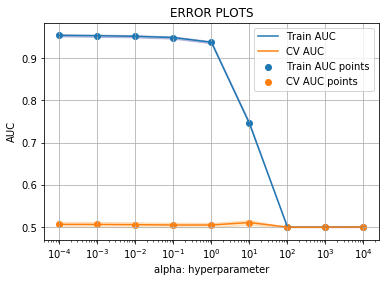

In [40]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV


algo = MultinomialNB(class_prior = [0.5, 0.5], fit_prior=True)
parameters = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
clf = GridSearchCV(algo, parameters, cv=5, scoring='roc_auc')
clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')

plt.xscale('log')

plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [41]:
# from the error plot we choose K such that, we will have maximum AUC on cv data and gap between the train and cv is less
# Note: based on the method you use you might get different hyperparameter values as best one
# so, you choose according to the method you choose, you use gridsearch if you are having more computing power and note it will take more time
# if you increase the cv values in the GridSearchCV you will get more rebust results.

#here we are choosing the best_k based on forloop results
best_alpha = 10

In [42]:
print(X_tr.shape)
print(X_te.shape)
print(y_train.shape)
print(y_test.shape)



(44887, 53888)
(33000, 53888)
(44887,)
(33000,)


In [43]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


clf = MultinomialNB(alpha=best_alpha)
clf.fit(X_tr, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs


y_train_pred = clf.predict(X_tr)
y_test_pred = clf.predict(X_te)



In [44]:
print(y_train.shape, y_test.shape)
print(len(y_train_pred), len(y_test_pred))

(44887,) (33000,)
44887 33000


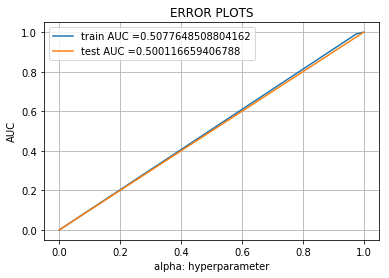

In [45]:
train_fpr, train_tpr, tr_threshold = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_threshold = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()


In [46]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def predict(proba, threshold, fpr, tpr):
    
    tr_threshold = threshold[np.argmax(train_tpr*(1-train_fpr))]
    te_threshold = threshold[np.argmax(test_tpr*(1-test_fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of train_tpr*(1-train_fpr)", max(train_tpr*(1-train_fpr)), "for threshold", np.round(tr_threshold,3))
    print("the maximum value of test_tpr*(1-test_tpr)", max(test_tpr*(1-test_tpr)), "for threshold", np.round(te_threshold,3))

    predictions = []
    for i in proba:
        if i>=tr_threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

   


In [47]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

the maximum value of train_tpr*(1-train_fpr) 0.02418799898106254 for threshold 1
the maximum value of test_tpr*(1-test_tpr) 0.009865347512238923 for threshold 1


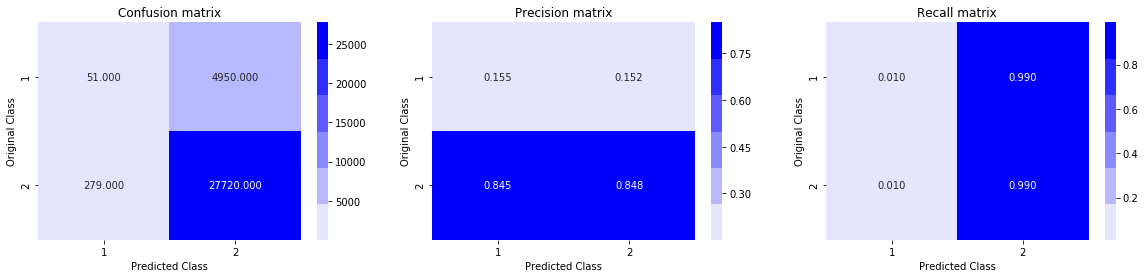

In [48]:
print("="*100)
plot_confusion_matrix(y_test, predict(y_test_pred, te_threshold, test_fpr, test_fpr))


In [49]:
def show_most_informative_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" %(coef_1, fn_1, coef_2, fn_2))

#### 2.4.1.1 Top 10 important features of positive and negative class from<font color='red'> SET 1</font>

In [50]:
show_most_informative_features(vectorizer, clf)

	-13.4223	crave          		-8.0414	learning       
	-13.4223	fuel our       		-8.4916	our            
	-13.4223	seeing believing		-8.5106	technology     
	-13.3577	bam            		-8.5145	classroom      
	-13.3577	baskets        		-8.6527	students       
	-13.3577	builders       		-8.6739	reading        
	-13.3577	building brain power		-8.7242	we             
	-13.3577	chromebooks part		-8.7927	help           
	-13.3577	digital storytelling		-8.8244	seating        
	-13.3577	fresh start    		-8.8496	books          


In [51]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

### 2.4.2 Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [52]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_title_tfidf, X_train_essay_tfidf, X_train_grade_ohe, X_train_teacher_ohe, X_train_state_ohe, subcategories_ohe_train, categories_ohe_train)).tocsr()
X_cr = hstack((X_cv_title_tfidf, X_cv_essay_tfidf, X_cv_grade_ohe, X_cv_teacher_ohe, X_cv_state_ohe, subcategories_ohe_cv, categories_ohe_cv)).tocsr()
X_te = hstack((X_test_title_tfidf, X_test_essay_tfidf, X_test_grade_ohe, X_test_teacher_ohe, X_test_state_ohe, subcategories_ohe_test, categories_ohe_test)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(44887, 53888) (44887,)
(22110, 53888) (22110,)
(33000, 53888) (33000,)


### Hyper parameter Tuning

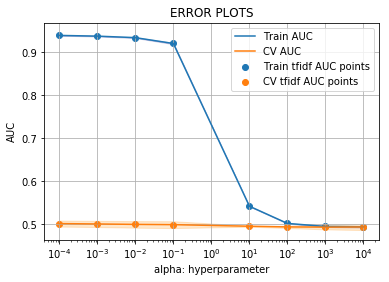

In [53]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html


algo = MultinomialNB(class_prior = [0.5, 0.5], fit_prior=True)
parameters = {'alpha':[0.0001, 0.001, 0.01, 0.1, 10, 100, 1000, 10000]}
clf = GridSearchCV(algo, parameters, cv=5, scoring='roc_auc')
clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train tfidf AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV tfidf AUC points')

plt.xscale('log')

plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()




In [54]:
best_alpha = 100
clf = MultinomialNB(alpha=best_alpha)
clf.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = clf.predict(X_tr)
y_test_pred = clf.predict(X_te)



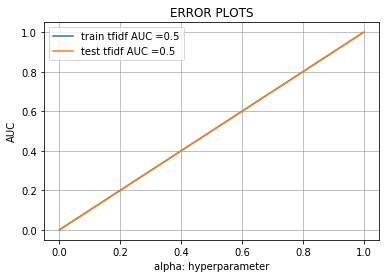

the maximum value of train_tpr*(1-train_fpr) 0.0 for threshold 2
the maximum value of test_tpr*(1-test_tpr) 0.0 for threshold 2


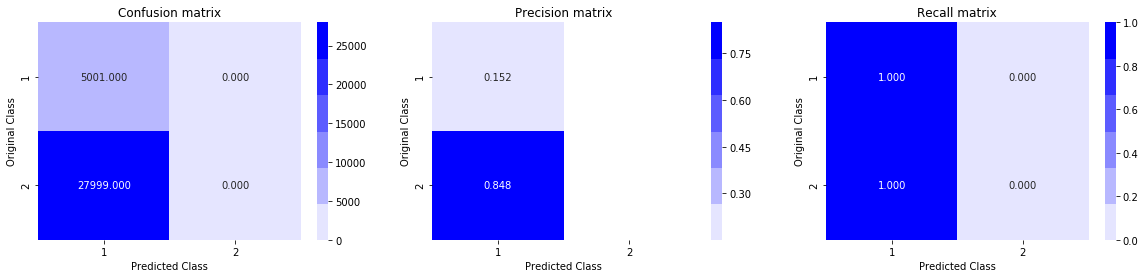

In [55]:

train_fpr, train_tpr, tr_threshold = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_threshold = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train tfidf AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test tfidf AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()


print("="*100)
plot_confusion_matrix(y_test, predict(y_test_pred, te_threshold, test_fpr, test_fpr))


#### 2.4.2.1 Top 10 important features of positive and negative class from<font color='red'> SET 2</font>

In [56]:
show_most_informative_features(vectorizer, clf)

	-11.0102	hear ye hear ye		-8.7861	learning       
	-11.0102	ye hear ye     		-9.0298	technology     
	-11.0080	10 prize       		-9.0733	classroom      
	-11.0080	10 prize winning		-9.1691	reading        
	-11.0080	10 prize winning toon		-9.2186	our            
	-11.0075	places you go  		-9.3077	students       
	-11.0070	hear ye hear   		-9.3083	seating        
	-11.0070	ye hear        		-9.3643	books          
	-11.0063	seeing believing		-9.3950	we             
	-11.0059	middle grades  		-9.4084	the            


<h2>2.5 Pretty Table </h2>

In [57]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyperparameter", "AUC"]

x.add_row(["BOW", "NB", 200, 0.50])
x.add_row(["TFIDF", "NB", 400, 0.50])


print(x)

+------------+-------+----------------+-----+
| Vectorizer | Model | Hyperparameter | AUC |
+------------+-------+----------------+-----+
|    BOW     |   NB  |      200       | 0.5 |
|   TFIDF    |   NB  |      400       | 0.5 |
+------------+-------+----------------+-----+


<h1>3. Conclusions</h1>

1. The Naiyve Bayes model on BOW vectorized data gives a slightly better AUC than the TGIDF.
2. All the models can be seen close to a random model.